In [3]:
import numpy as np
from numpy import array as ar
import matplotlib.pyplot as plt
import numpy.linalg as la

In [4]:
# This function is simply designed to take inputs about a linear landscape and return a V(x) vector.

def gen_landsape_linear(n_wells,depths,widths,seps):
    # There are several input variables we require:
    # n_wells: the number of stimulus-response pairings in the environment. 
    # depths: the depths of all wells; must be length of n_wells.
    # widths: the width of all wells; must be length of n_wells.
    # seps: the separation betewen wells; must be length of n_wells-1.

    # after this shift, depths = V(x), such that the deepest well has V(x)=0
    bg_height = np.max(depths);
    depths = bg_height-depths;

    # Now, we need to determine the width of the buffer region that allows
    # the TISE solutions to converge. This is a function of the minimum debroglie
    # wavelength for the whole system

    min_debroglie = (2*np.pi)/np.sqrt(2*bg_height)

    # the min debroglie wavelength also determines the resolution with which V(x)
    # is discretized

    dx = min_debroglie/((2**5)*np.pi)
    bg_width = 2*min_debroglie
    # We want to interleave the seps with the widths and have the bg_width on either side
    # This is not optimal. There's definitely a more efficient method of doing this, but we're on a time crunch.
    seps = np.append(bg_width,seps)
    widths = np.append([val for pair in zip(seps,widths) for val in pair],bg_width)

    # We want widths and depths of equal length and to describe the width and depth of the entire landscape
    fd = depths
    zd = bg_height*np.ones(len(fd))
    depths = np.append(bg_height,[val for pair in zip(fd,zd) for val in pair])

    # now we assign the number of steps in the V(x) vector for each depth value
    steps = np.ceil(widths/dx)

    # now we assign the number of steps in the V(x) vector for each depth value
    bound_idxs =np.append(0,np.cumsum(steps)).astype(int)
    V = np.zeros(int(np.sum(steps)))

    # finally, we fill in V with a simple for loop
    for i in range(len(bound_idxs)-1):
        V[bound_idxs[i]:bound_idxs[i+1]]=depths[i]

    return [dx,bound_idxs,V]


In [5]:
# this function solves the TISE for a linear landscape.

def solve_TISE_linear(n_wells,depths,widths,seps):

    landscape_info = gen_landsape_linear(n_wells,depths,widths,seps)
    dx = landscape_info[0]
    bound_idxs = landscape_info[1]
    vx = landscape_info[2]

    # now, we can get the variables back out that we need:
    n_steps = len(vx)
    bg_height = np.max(vx)

    # we will now execute the Numerov method for solving the TISE:
    # we start by embedding V(x) on the diagonal of an otherwise empty matrix
    V_mat = np.diag(vx,0)
    # and construct the matrices A and B in accordance with Pillai et al
    A = (-1/2)*(1/dx**(2))*(np.diag(-2*np.ones(n_steps),0)+np.diag(np.ones(n_steps-1),-1)+np.diag(np.ones(n_steps-1),1))
    B = (1/12)*(np.diag(10*np.ones(n_steps),0)+np.diag(np.ones(n_steps-1),-1)+np.diag(np.ones(n_steps-1),+1))
    D = la.eig(np.dot(la.inv(B),A)+V_mat)

    # The eigen values that sit below background energy give the bound eigen energies
    # their corresponding eigen vectors give the eigenstates of the system
    # the l2 norm of these gives the PDF. 
    eig_vals = D[0]
    eig_vecs = D[1]
    idx = eig_vals.argsort()#[::-1]   
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    bound_state_idx = np.squeeze(np.where(eig_vals<bg_height))
    bound_energies = eig_vals[bound_state_idx]
    n_energies = len(bound_state_idx)
    bound_states = np.squeeze(eig_vecs[:,bound_state_idx])
    pdfs = bound_states*bound_states

    # We finally return the normalized PDFs here.
    pdf_ints = np.trapz(pdfs,axis = 0)
    normd_pdfs = pdfs / np.transpose(pdf_ints[:, np.newaxis])

    # And, in order to get the MIEs, we simply integrate from the lower to the upper bound
    # of each well. This could probably be vectorized to avoid the for loop. 
    sample_pdf = normd_pdfs[:,0]
    M_set = np.empty((n_energies,n_wells))
    for well in range(n_wells):
        M_set[:,well] = np.trapz(normd_pdfs[bound_idxs[2*well+1]:bound_idxs[2*well+2]],axis=0)

    return [bound_energies,pdfs,M_set]

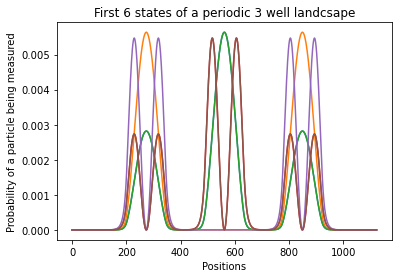

In [7]:
n_wells = 3;
depths = 10*np.ones(n_wells)#+0.01*np.random.rand(n_wells)
widths = 2*np.ones(n_wells)#+np.random.rand(n_wells)
seps = 2*np.ones(n_wells-1)#+np.random.rand(n_wells-1)
pdf_info = solve_TISE_linear(n_wells,depths,widths,seps)
bound_e = pdf_info[0]
pdfs = pdf_info[1]
MIEs = pdf_info[2]

# we run a quick check on the states here:
plt.figure()
plt.plot(pdfs[:,0:6])
plt.title('First 6 states of a periodic 3 well landcsape')
plt.xlabel('Positions')
plt.ylabel('Probability of a particle being measured')
plt.show()